____
____
# Homework 5: Kaggle Competition
#### Rouzbeh Salehi Pour
____
____

In [7]:
import numpy as np
import pandas as pd

from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set_style("whitegrid")

from PIL import Image

from tqdm import tqdm

from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras import regularizers, optimizers

____

## Introduction

### Problem Description
- This report is based off the [Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection/overview) Kaggle competition.
- The goal of the competition is to develop "an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans".
- Two folders and two csv files have been provided:
    - Folders:
        - train: contains .tif images of pathology scans used to train the algorithm.
        - test: contains .tif images of pathology scans used to test the performance of the algorithm. 
    - csv files:
        - train_labels: contains the name and metastatic cancer status of each .tif file in the train folder.
        - sample_submission: contains the name of each .tif file in the test folder.
- The algorithm will be a supervised learning Convolutional Neural Network (CNN) model.
- As allowed in homework description, various external sources have been used to develop the contents of this report.
    - All external sources will be quoted in text (for writups/descriptions) or in comments (for code) wherever they are used.

### GitHub Repository
- https://github.com/rouzbehs/CSCP-3202-HW5

### Data Description

#### Folders

In [8]:
# source of code: https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory

train_path = 'data/train'     # path of training images 
test_path = 'data/test'     # path of test images 

# for each file in the directory, add its name to a list
train_file_names = [f for f in listdir(train_path) if isfile(join(train_path, f))]
test_file_names = [f for f in listdir(test_path) if isfile(join(test_path, f))]

In [9]:
print(len(train_file_names))
print(len(test_file_names))

220025
57458


In [10]:
print(train_file_names[:3])
print(test_file_names[:3])

['00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif', '000020de2aa6193f4c160e398a8edea95b1da598.tif', '00004aab08381d25d315384d646f5ce413ea24b1.tif']
['00006537328c33e284c973d7b39d340809f7271b.tif', '0000ec92553fda4ce39889f9226ace43cae3364e.tif', '00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif']


In [11]:
# 1st source of code: https://stackoverflow.com/questions/138250/how-to-read-the-rgb-value-of-a-given-pixel-in-python
# 2nd source of code: https://keras.io/api/preprocessing/image/

train_pic = load_img(train_path + '/' + train_file_names[0])
test_pic = load_img(test_path + '/' + test_file_names[0])
print(train_pic.size)
print(test_pic.size)

(96, 96)
(96, 96)


- As mentioned in the section above, there are two folders containing .tif image files, one for training and one for testing of the algorithm.
- All images are of size 96x96 pixels.
- There are 220,025 training images and 57,458 testing images.

#### csv Files

In [12]:
train_df = pd.read_csv('data/train_labels.csv', dtype={'label':'int8'})
test_df = pd.read_csv('data/sample_submission.csv', dtype={'label':'int8'})

In [13]:
print(train_df.shape)
print(test_df.shape)

(220025, 2)
(57458, 2)


In [14]:
# ##########################################################################################
# train_df = train_df.sample(30000)
# print(train_df.shape)
# ##########################################################################################

In [15]:
train_df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [16]:
train_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [17]:
test_df.head(3)

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0


In [18]:
test_df['label'].value_counts()

0    57458
Name: label, dtype: int64

- The train_labels table contains the names of all 220,025 images in the train folder and their metastatic cancer statuses.
    - Label value 1 = cancer is present, label value 0 = caner is not present. 
- The sample_submission table contains the names of all 57,458 images in the test folder, but has 0 values for the label column since its purpose is to be a template of what to submit to the Kaggle competition.
    - Prediction results from the algorithm will fill in the label column. 

____

## Exploratory Data Analysis

- The process and ideas of how to go about the EDA for this project and report was inspired by [this notebook submission](https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93) to the same Kaggle competition.
- Plan of analysis:
    - Present a few images from the train folder and look for visual features.
    - Extract the RGB values of a sample of images.
    - Analyse the distribution and quantiles of the image color channels.
- As instructed by the course professor in [this Piazza post](https://piazza.com/class/kdwewp0f15e6sa?cid=103), no cleaning is needed for this dataset.

### Image Samples

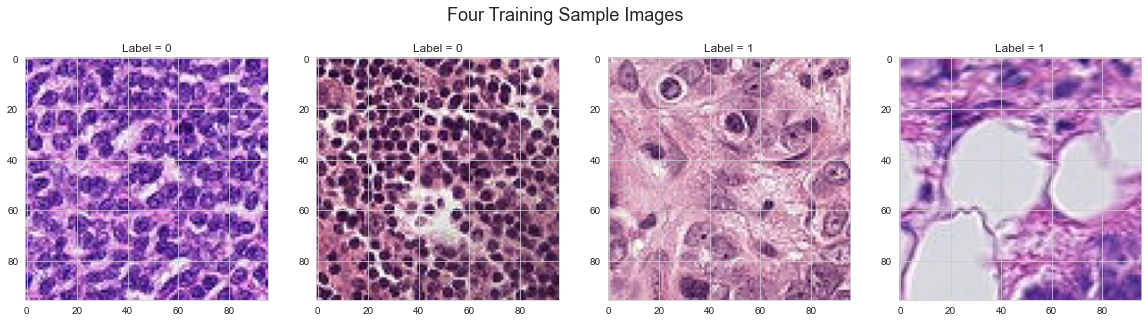

In [19]:
fig,ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))

# print random images based on label values
def random_images(label_values):
    for i in range(4):
        image_name = str(train_df[train_df['label'] == label_values[i]].sample().values[0][0]) + '.tif'     # extract random row of df and take its image name
        image = Image.open(train_path + '/' + image_name)     # import the image
        ax[i].imshow(image)
        ax[i].set_title('Label = ' + str(label_values[i]))
    fig.suptitle('Four Training Sample Images', fontsize=18);
        
label_values = [0, 0, 1, 1]
random_images(label_values)

- Above are random samples of training images.
- After running the code and viewing different images multiple times, it is evident that there are no obvious defining features that would visually separate images with different label values.

### Data Distribution
- Since we are dealing with images, each of their RGB color channel values can be extracted and further explored.
    - Only 2000 random images of each label value are chosen for RGB value extraction to save time and memory.
- Before this is done, the dataframes will be edited to include a columns with the file name and file type, not just the file name as it is currently designed.
    - This will make it easier to extract the images.

In [20]:
# add .tif to all file names

def add_file_type_to_name(df):
    df['id_tif'] = df.id + '.tif'
    df = df[['id_tif', 'id', 'label']]
    return df

train_df = add_file_type_to_name(train_df)
test_df = add_file_type_to_name(test_df)

train_df.head(3)

,id_tif,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,755db6279dae599ebb4d39a9123cce439965282d,0


In [21]:
# extract the rgb values from images

def extract_rgb(folder_path, label_value):
    rgb_values = []
    for i in tqdm(train_df[train_df['label'] == label_value]['id_tif'].sample(2000), colour='green'):     # filter all items that have a label value of 0 and sample 5000 of them
        image = load_img(folder_path + '/' + i)     # load the image
        array = img_to_array(image)     # take the pixel values of the image
        rgb_values.append(array)
    return np.asarray(rgb_values)

rgb_label0 = extract_rgb(train_path, 0)
rgb_label1 = extract_rgb(train_path, 0)

100%|██████████| 2000/2000 [00:12<00:00, 165.77it/s]


In [22]:
print(rgb_label0.shape)
print(rgb_label1.shape)

(2000, 96, 96, 3)
(2000, 96, 96, 3)


In [23]:
# flatten nested arrays into one array

rgb_label0_R = rgb_label0[:, :, :, 0].flatten()
rgb_label0_G = rgb_label0[:, :, :, 1].flatten()
rgb_label0_B = rgb_label0[:, :, :, 2].flatten()

rgb_label1_R = rgb_label1[:, :, :, 0].flatten()
rgb_label1_G = rgb_label1[:, :, :, 1].flatten()
rgb_label1_B = rgb_label1[:, :, :, 2].flatten()

rgb_separated = pd.DataFrame({'Label 0, Red value':rgb_label0_R, 'Label 1, Red':rgb_label1_R, 
                              'Label 0, Green':rgb_label0_G, 'Label 1, Green':rgb_label1_G, 
                              'Label 0, Blue':rgb_label0_B, 'Label 1, Blue':rgb_label1_B})

rgb_separated.head()

,"Label 0, Red value","Label 1, Red","Label 0, Green","Label 1, Green","Label 0, Blue","Label 1, Blue"
0,244.0,252.0,244.0,251.0,242.0,247.0
1,243.0,250.0,243.0,250.0,241.0,248.0
2,242.0,249.0,242.0,251.0,240.0,248.0
3,243.0,246.0,243.0,251.0,241.0,247.0
4,244.0,246.0,244.0,251.0,242.0,247.0


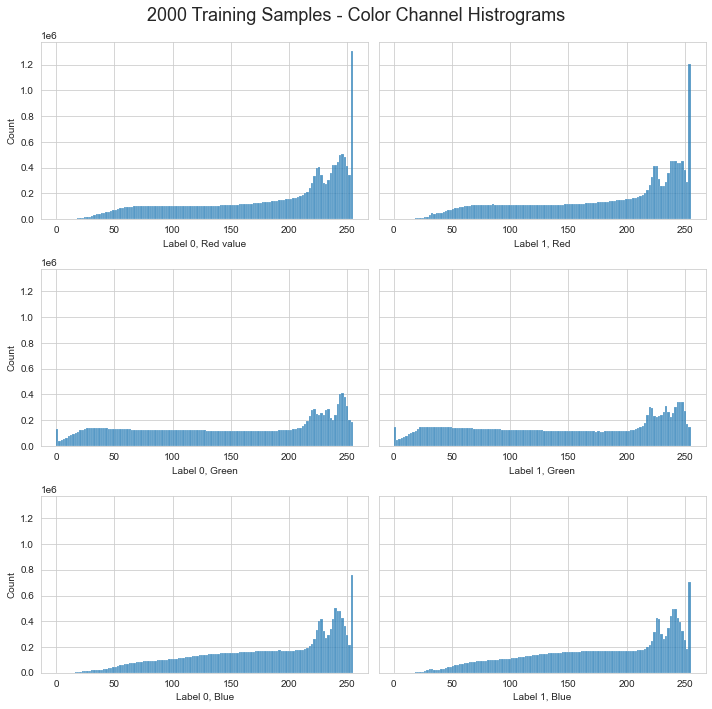

In [24]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10, 10), sharey=True)
plt.subplots_adjust(wspace=0.4)

df = rgb_separated

row = 0
col = 0

for att in df.columns:
    sns.histplot(df[att], label=att, bins=255//2, ax=ax[row][col]) 
    col += 1
    if col == ax.shape[0]-1:
        row += 1
        col = 0
      
fig.suptitle('2000 Training Samples - Color Channel Histrograms', fontsize=18);
fig.tight_layout()

In [25]:
rgb_separated.describe()

,"Label 0, Red value","Label 1, Red","Label 0, Green","Label 1, Green","Label 0, Blue","Label 1, Blue"
count,1.843200e+07,1.843200e+07,1.843200e+07,1.843200e+07,1.843200e+07,1.843200e+07
mean,1.815592e+02,1.782047e+02,1.469072e+02,1.429269e+02,1.792601e+02,1.770425e+02
std,6.497038e+01,6.563684e+01,7.691143e+01,7.740867e+01,5.960936e+01,5.987598e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.310000e+02,1.250000e+02,7.800000e+01,7.300000e+01,1.340000e+02,1.320000e+02
50%,2.040000e+02,1.990000e+02,1.540000e+02,1.470000e+02,1.920000e+02,1.880000e+02
75%,2.380000e+02,2.360000e+02,2.210000e+02,2.200000e+02,2.320000e+02,2.310000e+02
max,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02,2.550000e+02


- The color channel histograms do not show much of a difference between the color distributions of images with label values of 0 vs. images with label values of 1.
    - This is further supported by the table above showing the similarities in the specific quantiles of each color channel for each label value. 
- For both sets of label values, both red and blue color distributions show a large spike at ~255, indicating that the images are fairly saturated in those colors.

In [26]:
# flatten nested arrays into one array for average pixel values

rgb_label0_avg = rgb_label0.mean(axis=3).flatten()
rgb_label1_avg = rgb_label1.mean(axis=3).flatten()

rgb_average = pd.DataFrame({'Label 0':rgb_label0_avg, 'Label 1':rgb_label1_avg})

rgb_average.head()

,Label 0,Label 1
0,243.333328,250.000000
1,242.333328,249.333328
2,241.333328,249.333328
3,242.333328,248.000000
4,243.333328,248.000000


In [27]:
rgb_average.shape

(18432000, 2)

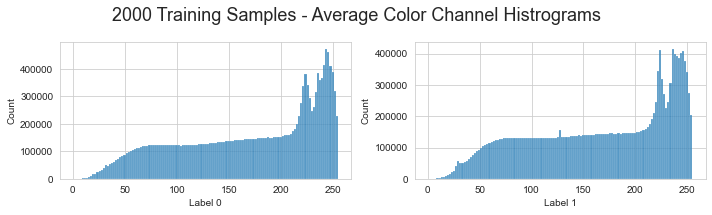

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
plt.subplots_adjust(wspace=0.4)

df = rgb_average
col = 0

for att in df.columns:
    sns.histplot(df[att], label=att, bins=255//2, ax=ax[col])
    col += 1
    
fig.suptitle('2000 Training Samples - Average Color Channel Histrograms', fontsize=18);
fig.tight_layout()

In [29]:
rgb_average.describe()

,Label 0,Label 1
count,1.843200e+07,1.843200e+07
mean,1.692424e+02,1.660584e+02
std,6.591306e+01,6.635891e+01
min,6.666667e-01,3.333333e-01
25%,1.146667e+02,1.100000e+02
50%,1.826667e+02,1.770000e+02
75%,2.290000e+02,2.270000e+02
max,2.550000e+02,2.550000e+02


- As expected, the same similarities in distribution are present when averaging the RGB values per per pixel per image.
- There are no defining features in the color channels that would separate label = 0 images from label = 1 images.

____

## Model

- The architecture and especially the method of how to implement a CNN was inspired by [this medium article](https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c) which provides a walk-through of how to use the _flow_from_dataframe_ method in Keras and how to build a CNN using Keras.
    - This medium article was discovered via a link from the Keras API reference page for [image data preprocessing](https://keras.io/api/preprocessing/image/).
- This [pyimagesearch arcticle](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/) were also used to get a good understanding of the Keras Conv2D class and to help with the model building as well.
- This [TensorFlow tutorial](https://www.tensorflow.org/tutorials/images/classification) on image classification was used when implementing and visualizing the model fit.

### Reading Data

- The _ImageDataGenerator_ class in Keras allows for generating "batches of tensor image data with real-time data augmentation".
    - This provides a method of: 
        - Taking in images in batches to avoid a memory crash when dealing with large datasets; and
        - Performing any manipulatoins to these images to increase the dataset size.
- The _flow_from_dataframe_ method from the _ImageDataGenerator_ class allows the user to read images from storage based on the path provided, therefore there is no need to split training, validation, or testing images into separate folders.

In [24]:
train_valid_split = 0.8
data = ImageDataGenerator(rescale=1./255., 
                          validation_split=train_valid_split)

- Arguments for _ImageDataGenerator_:
    - Rescaling is done to prevent larger ranged images (those with unsaturated and saturated colors) from having more of an affect on weight updates, as explained [here](https://www.linkedin.com/pulse/keras-image-preprocessing-scaling-pixels-training-adwin-jahn#:~:text=Rescale%201.%2F255%20is%20to,some%20are%20low%20pixel%20range.&text=Scaling%20every%20images%20to%20the,evenly%20to%20the%20total%20loss.).
    - Validation split is implemented to split training data to training and validation sets.

In [25]:
train_batch_size = 32

- A training batch size of 32 was used since this seems to be the go-to value for most CNN tutorials online.

In [26]:
print(train_df.shape)

(220025, 3)


In [27]:
# set up reading for training data

train_flow = data.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='raw',     # numpy of values in y_col argument
    batch_size=train_batch_size,
    shuffle=True,
    save_format='tif',
    subset='training'
)

Found 44005 validated image filenames.


In [28]:
# set up reading for validation data

valid_flow = data.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='raw',     # numpy of values in y_col argument
    batch_size=train_batch_size,
    shuffle=True,
    save_format='tif',
    subset='validation'
)

Found 176020 validated image filenames.


In [29]:
# check that train and validation split sizes sum to training data size

assert train_df.shape[0] == len(train_flow.labels) + len(valid_flow.labels)

### Model Building

- The model itself is categorized into two parts:
    - Feature extractor: comprised of three sets of two convolution layers followed by a pooling layer.
    - Classifier: simple dense layer with a single node for the output layer.
- Reasons for this architecture:
    - Since I havn't had any experience with CNNs or even ANNs, the initial model build was based off parts of the tutorials cited at the top of this section.
        - From there on, I began to tweak certain hypeparameters to see their effects, which are discussed in the Results section below.
    - My main goal was the keep the CNN architecture simple so I could easily understand what is going on and be able to follow the model summary below with confidence. 
        - As explained above, the first part of the feature extractor is two convolution layers with relu activation, followed by an average pooling layer, and completed with a batch normalization for regularization to avoid overfitting.
        - This structure is repeated in the second and third part of the feature extractor but with a larger number of filters.
        - The classifier flattens the nodes of the convolution layer into a dense layer which ends with a single output node. 
        - Adam optimizer is used with a decaying learning rate.

In [30]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same", input_shape=(96, 96, 3)))
model.add(Activation('relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), padding="same"))
model.add(Activation('relu'))
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2,2), padding="same"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, decay=1e-5), loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 16)        448       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 16)        2320      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 48, 48, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4

### Model Fitting

In [31]:
epochs = 10

history = model.fit(
    x=train_flow,
    batch_size=train_flow.batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=valid_flow,
    steps_per_epoch=train_flow.n//train_flow.batch_size,
    validation_steps=valid_flow.n//valid_flow.batch_size,
    workers=99
)

Epoch 1/10
1375/1375 [==============================] - 454s 330ms/step - loss: 0.4927 - accuracy: 0.7688 - val_loss: 0.4378 - val_accuracy: 0.8015
Epoch 2/10
1375/1375 [==============================] - 441s 321ms/step - loss: 0.4290 - accuracy: 0.8101 - val_loss: 0.3833 - val_accuracy: 0.8379
Epoch 3/10
1375/1375 [==============================] - 427s 311ms/step - loss: 0.3839 - accuracy: 0.8341 - val_loss: 0.3450 - val_accuracy: 0.8521
Epoch 4/10
1375/1375 [==============================] - 422s 307ms/step - loss: 0.3605 - accuracy: 0.8444 - val_loss: 0.3295 - val_accuracy: 0.8571
Epoch 5/10
1375/1375 [==============================] - 425s 309ms/step - loss: 0.3375 - accuracy: 0.8557 - val_loss: 0.3052 - val_accuracy: 0.8699
Epoch 6/10
1375/1375 [==============================] - 428s 311ms/step - loss: 0.3224 - accuracy: 0.8632 - val_loss: 0.2916 - val_accuracy: 0.8776
Epoch 7/10
1375/1375 [==============================] - 427s 311ms/step - loss: 0.3047 - accuracy: 0.8702 - val_

____

## Results

### Validation

In [32]:
train_acc, train_loss = history.history['accuracy'], history.history['loss']
valid_acc, valid_loss = history.history['val_accuracy'], history.history['val_loss']

In [33]:
accuracy = pd.DataFrame({'Training Accuracy':train_acc, 'Validation Accuracy':valid_acc})
loss = pd.DataFrame({'Training Loss':train_loss, 'Validation Loss':valid_loss})

# increasing index value to match epoch (start at 1)
accuracy.index += 1 
loss.index += 1 

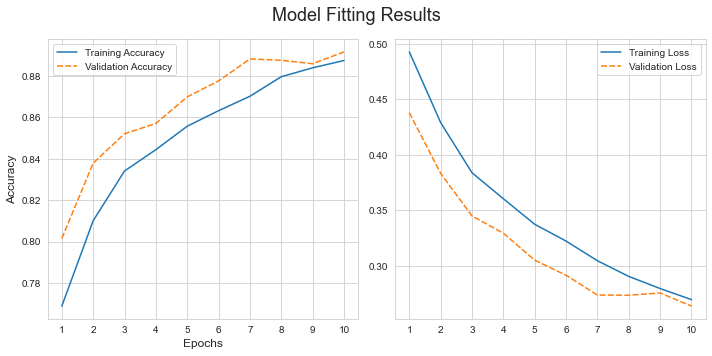

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)
plt.subplots_adjust(wspace=0.4)

sns.lineplot(data=accuracy, ax=ax[0])
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)

sns.lineplot(data=loss, ax=ax[1])
ax[0].set_xlabel('Epochs', fontsize=12)
ax[0].set_ylabel('Accuracy', fontsize=12)

ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    
fig.suptitle('Model Fitting Results', fontsize=18);
fig.tight_layout()

- The results of the model give the following performance values after 10 epochs:
    - Training accuracy: ~0.89 | training loss: ~0.29
    - Validation accuracy: ~0.89 | validation loss: ~0.26
- From epoch vs. performance plots above, I was initially very confused as to why model performance was better during validation that training, albeit by a very little amount.
    - I managed to find the answer to this from [this question board](https://www.researchgate.net/post/When_can_Validation_Accuracy_be_greater_than_Training_Accuracy_for_Deep_Learning_Models) where it is explained that the use of dropout makes it more difficult for the model to find the right answers since some nodes are 'dropped-out' in training. All nodes however exist during validation, which allows for a better model performance.
- I spent A LOT of time (more than I care to admit) tuning the hyperparameters of the model to try and get a performance with relatively high accuracy and similar training and validation scores.
    - As mentioned before, the model was initially inspired by the sources mentioned.
    - The training dataframe was temporarily cut to 30,000 entries to be able to tune and see the results of the model in a timely manner.
    - Three sets of two convolutional layers and pooling were used since it gave better performance than two sets.
        - The number of sets was the further increased to maintain simplicity.
    - Average pooling with 2x2 strides for all three sets of two convolutional layers were used since it would consider each pixel value equally in the next convolution layer compared to max pooling.
    - Kernel sizes were always kept at 3x3 and never increased because, as mentioned in the class lecture for CNN architecture, two 3x3 filters is computationally easier to perform than a single 5x5 filter.
        - The strides for the filters were kept at 1x1 for the first two convolution sets, while the third convolution set was changed to 2x2 due to the larger number of filers.
    - The number of filters for each convolution sets were chosen due to the recommendations given by the noted previous sources, where they state that deeper layers use more filters to extract more features. 
    - The relu activation function was used for all layers and never changed since all online and class tutorials used relu as the go-to activation function. 
    - Initially, the final output node used a softmax activation function with a categorical cross entropy loss type for the optimizer, but this mistake was later recognized because this project deals with binary result, therefore the softmax and binary cross entropy loss were used instead.
        - This simple change noticeably improved the model performance.
    - For regularization, batch normalization was initially used.
        - This resulted in large variations in the validation performance values, making it difficult to predict the accuracy and loss based on the training values. 
            - One of the major goals was to eliminate these large variations.
        - Even with the combination of batch normalization and dropout, the large fluctuations in validation performance values existed.
        - The use of dropout on its own and eliminating batch normalization proved to be a significant change in eliminating these fluctuations; therefore, only dropout is used for normalization.
            - Eliminating batch normalization also almost doubled the speed of the model fitting process since it eliminated millions of normalization calculations across multiple epochs (I wish I knew to do this sooner).
    - The Adam optimizer performed better than RMSprop, and the final learning rate used provided the best performance.
        - Changing the decay by an order of magnitude with a fixed learning rate did not have too much of an impact on the final performance of the model when dealing with the cut database.

### Testing

In [35]:
test_df.shape

(57458, 3)

In [36]:
test_data = ImageDataGenerator(rescale=1./255.)

In [37]:
test_batch_size = 2

- A test bactch size of 2 was used since no other value other than 1 would perfectly divide the number of test images.

In [39]:
# set up reading for test data

test_flow = data.flow_from_dataframe(
    dataframe=test_df,
    directory=test_path,
    x_col='id_tif',
    y_col='label',
    target_size=(96, 96),
    color_mode='rgb',
    class_mode='raw',     # numpy of values in y_col argument
    batch_size=test_batch_size,
    shuffle=False,
    save_format='tif'
)

Found 57458 validated image filenames.


In [40]:
test_flow.reset()

In [41]:
predictions = model.predict(x=test_flow, 
                            steps=test_flow.n//test_flow.batch_size, 
                            verbose=1, 
                            workers=99
                           )

28729/28729 [==============================] - 159s 6ms/step


In [42]:
test_df.head()

,id_tif,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737.tif,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf.tif,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [43]:
submission = pd.DataFrame({'id':test_df['id'], 'label':predictions.flatten()})

In [44]:
submission.shape

(57458, 2)

In [45]:
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.009573
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.084746
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.014378
3,2c35657e312966e9294eac6841726ff3a748febf,0.045408
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.097023


In [46]:
submission.to_csv('submission.csv', index=False)

- Submission of the testing results to the Kaggle competition yielded a score of 0.9281.
    - Since the competition ended two years ago, late submissions are not included in the leaderboard, however, based on the leaderboard two years ago, the score of 0.9281 would have been in  707th place.

- Submission proof:

![Submission proof](submission_proof.png "Submission proof")

- Private leaderboard standings at the end of the competition:

![Leaderboard](leaderboard.png "Leaderboard")

____

## Conclusion

- Being able to finally complete this homework/competition was definitely very rewarding at the end, however it was also very difficult to implement.
- Since this was my first implementation of CNN, it took a while to understand how images are brought in to be read and processed via code. 
    - After many tries of different methods, the tutorials sourced above provided the biggest help with the use of the ImageDataGenerator from the keras preprocessing library.
- Hyperparameter tuning, although fun to experiment with, was time consuming when dealing with such a large database.
    - The biggest worry of temporarily cutting the database to decrease processing time was that the results of the final tuned hyperparameters would not work well with the full database.
- Nonetheless, keeping the model simple and understandable was the best choice in maximizing my learning experience with this homework.